In [1]:
#!conda env list

## 1 Set API Key

In [2]:
import os
from openai import OpenAI 

## Set the API key and model name
MODEL="gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")
client = OpenAI(api_key=api_key)

### 1.1 Try out functionality

In [3]:
completion = client.chat.completions.create(
  model=MODEL,
  messages=[
    {"role": "user", "content": "You are a helpful recruiting assistant. We have a list of candidates we want to interview for a job and we want to tailor interview questions to their skills."}, # <-- This is the system message that provides context to the model
    {"role": "system", "content": f"Hello! Based on the following candidates:, could you make a list of 5 interview questions for all of them based on their total pool of skills and how it relates to the skills required of the job - here:  "}  # <-- This is the user message for which the model will generate a response
  ]
)

In [4]:
from IPython.display import display, Markdown, Latex
display(Markdown(completion.choices[0].message.content))

I would be happy to help you with that! However, I’ll need some specific information about the candidates you have in mind, including their skills and the requirements of the job. Please provide me with those details, and I can generate tailored interview questions for you.

### 1.2 Create Dataframe with Job Descriptions

In [5]:
ls

LICENSE                      job_descriptions/
LLM.ipynb                    main.py
README.md                    services/
Resources/                   source/
__pycache__/                 synthetic_data.ipynb
agenda.md                    synthetic_data_binary.ipynb
comparison.ipynb             user_interface/
environment.yml              word_embeddings.ipynb
environment_mac.yml


In [6]:
import os
import pandas as pd

job_descriptions_path = 'job_descriptions/'
files = [f for f in os.listdir(job_descriptions_path) if f.endswith('.txt')]
jobs = []

for i, filename in enumerate(files):
    with open(os.path.join(job_descriptions_path, filename), 'r', encoding='utf-8') as f:
        content = f.read().strip()
        
        # If the Job Title is the first line of the file
        lines = content.split('\n')
        job_title = lines[0]  # Assuming the first line is the Job Title
        jd = '\n'.join(lines[1:])  # The rest is the Job Description
        
        # If the Job Title is derived from the filename instead, uncomment the next line
        # job_title = os.path.splitext(filename)[0]  # Filename without extension
        
        jobs.append({
            'Job ID': i + 1,
            'Job Title': job_title,
            'JD': jd
        })

df_jobs = pd.DataFrame(jobs)
df_jobs

,Job ID,Job Title,JD
0,1,,
1,2,,
2,3,,
3,4,,
4,5,,
5,6,"Machine Learning Engineer, Sage, London",\nFull job description\n\nAbout our Team:\nThe...
6,7,,
7,8,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...
8,9,Data Scientist,Lisbon\n\n\n\nApply on employer site\n\n\nAppl...
9,10,Junior Data Engineer,"At Capgemini Engineering, the world leader in ..."


In [7]:
job_titles_to_keep = [
    'Senior Data Scientist, WTW, London',
    'Software Engineer II, Android, Microsoft, London'
]

df_filtered = df_jobs[df_jobs['Job Title'].isin(job_titles_to_keep)].reset_index(drop=True)
df_filtered['Job ID'] = df_filtered.index + 1
df_filtered

,Job ID,Job Title,JD
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...
1,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...


## Binary 

### New Approach for Creating Synthetic Data with Clear Skill Match Separation

#### Goal
The goal is to create a synthetic dataset that generates three resumes per job description (JD) with a perfect to very good fit to the skills mentioned in the JD. Additionally, in a separate API call, three resumes will be generated for each job description that have a poor skill match to the JD.

#### Approach

1. **Creating Resumes with Good Fit:**
    - For each job description, three resumes will be generated.
    - These resumes should have a perfect to very good fit to the skills mentioned in the JD.
    - These resumes will be created in the first API call.

2. **Creating Resumes with Poor Fit:**
    - For each job description, three additional resumes will be generated.
    - These resumes should have a poor skill match to the JD, meaning they contain irrelevant skills that do not align or relate to the skills mentioned in the JD.
    - These resumes will be created in a second, separate API call.

#### Next Steps
In the next step, we will create the code to implement this approach. The code will:
- Iterate through the job descriptions.
- Generate three resumes with a good fit for each job description.
- Generate three resumes with a poor fit for each job description.
- Store and display the generated resumes in a DataFrame.

This approach aims to ensure that the generated resumes have clearly distinguishable skill matches, providing a better foundation for further analysis.

### good fit resumes 

In [8]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to simulate clearly differentiable levels of fit between candidates and the provided job description only based on skill alignment.
The ranking **must not depend** on any other factor except of the skills mentioned in the resume and the job description. 
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for a candidate applying for the following tech job. Assign a **ranking from 1 to 3** to the resume based on the alignment of skills.

The level of fit should be clearly separable to each other and labeled with a number from 1 to 3, where:
- **1 = Perfect Fit** (perfect alignment of skills and related skills between resume and job description).
- **2 = Very Good Fit** (very good alignment of skills and related skills between resume and job description).
- **3 = Good Fit** (good alignment of skills and related skills between resume and job description).

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_good_{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_1,Candidate_1_good_1,**Resume: John Smith** \n[Email: john.smith@e...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_2,Candidate_1_good_2,**Candidate Name:** Johnathan Smith \n**Addre...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_3,Candidate_1_good_3,**Resume**\n\n**Name:** Emma Thompson \n**Ema...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_1,Candidate_2_good_1,**Candidate Name:** Emily Johnson \n**Locatio...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_2,Candidate_2_good_2,**Candidate Resume:**\n\n**Name:** Emma Carter...,2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_3,Candidate_2_good_3,**Resume for Candidate: James Anderson**\n\n**...,3


In [11]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /good fit resumes 23.11"


# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_good_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)


In [12]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with poor fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to simulate clearly differentiable levels of fit between candidates and the provided job description only based on skill alignment.
The ranking **must not depend** on any other factor except of the skills mentioned in the resume and the job description. 
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for a candidate applying for the following tech job. Assign a **ranking from 1 to 3** to the resume based on the alignment of skills.

The level of fit should be clearly separable to each other and labeled with a number from 1 to 3, where:
- **1 = Poor Fit** (poor alignment of skills and related skills between resume and job description).
- **2 = Very Poor Fit** (very poor alignment of skills and related skills between resume and job description).
- **3 = No Fit** (no alignment of skills and related skills between resume and job description - the candidate comes from another field entirely, such as marketing or finance).

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_poor_{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_1,Candidate_1_poor_1,**Candidate Name:** John Doe \n**Contact Info...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_2,Candidate_1_poor_2,**Candidate Resume: John Doe** \n[Contact Inf...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_3,Candidate_1_poor_3,**Resume**\n\n**Name:** John Smith \n**Addres...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_1,Candidate_2_poor_1,**Candidate Name:** Sarah Thompson \n**Contac...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_2,Candidate_2_poor_2,**Resume for Candidate: John Smith**\n\n**Cont...,2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_3,Candidate_2_poor_3,"**Resume**\n\n**John Smith** \nLondon, UK \n...",3


In [14]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /bad fit resumes 23.11"


# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_poor_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)


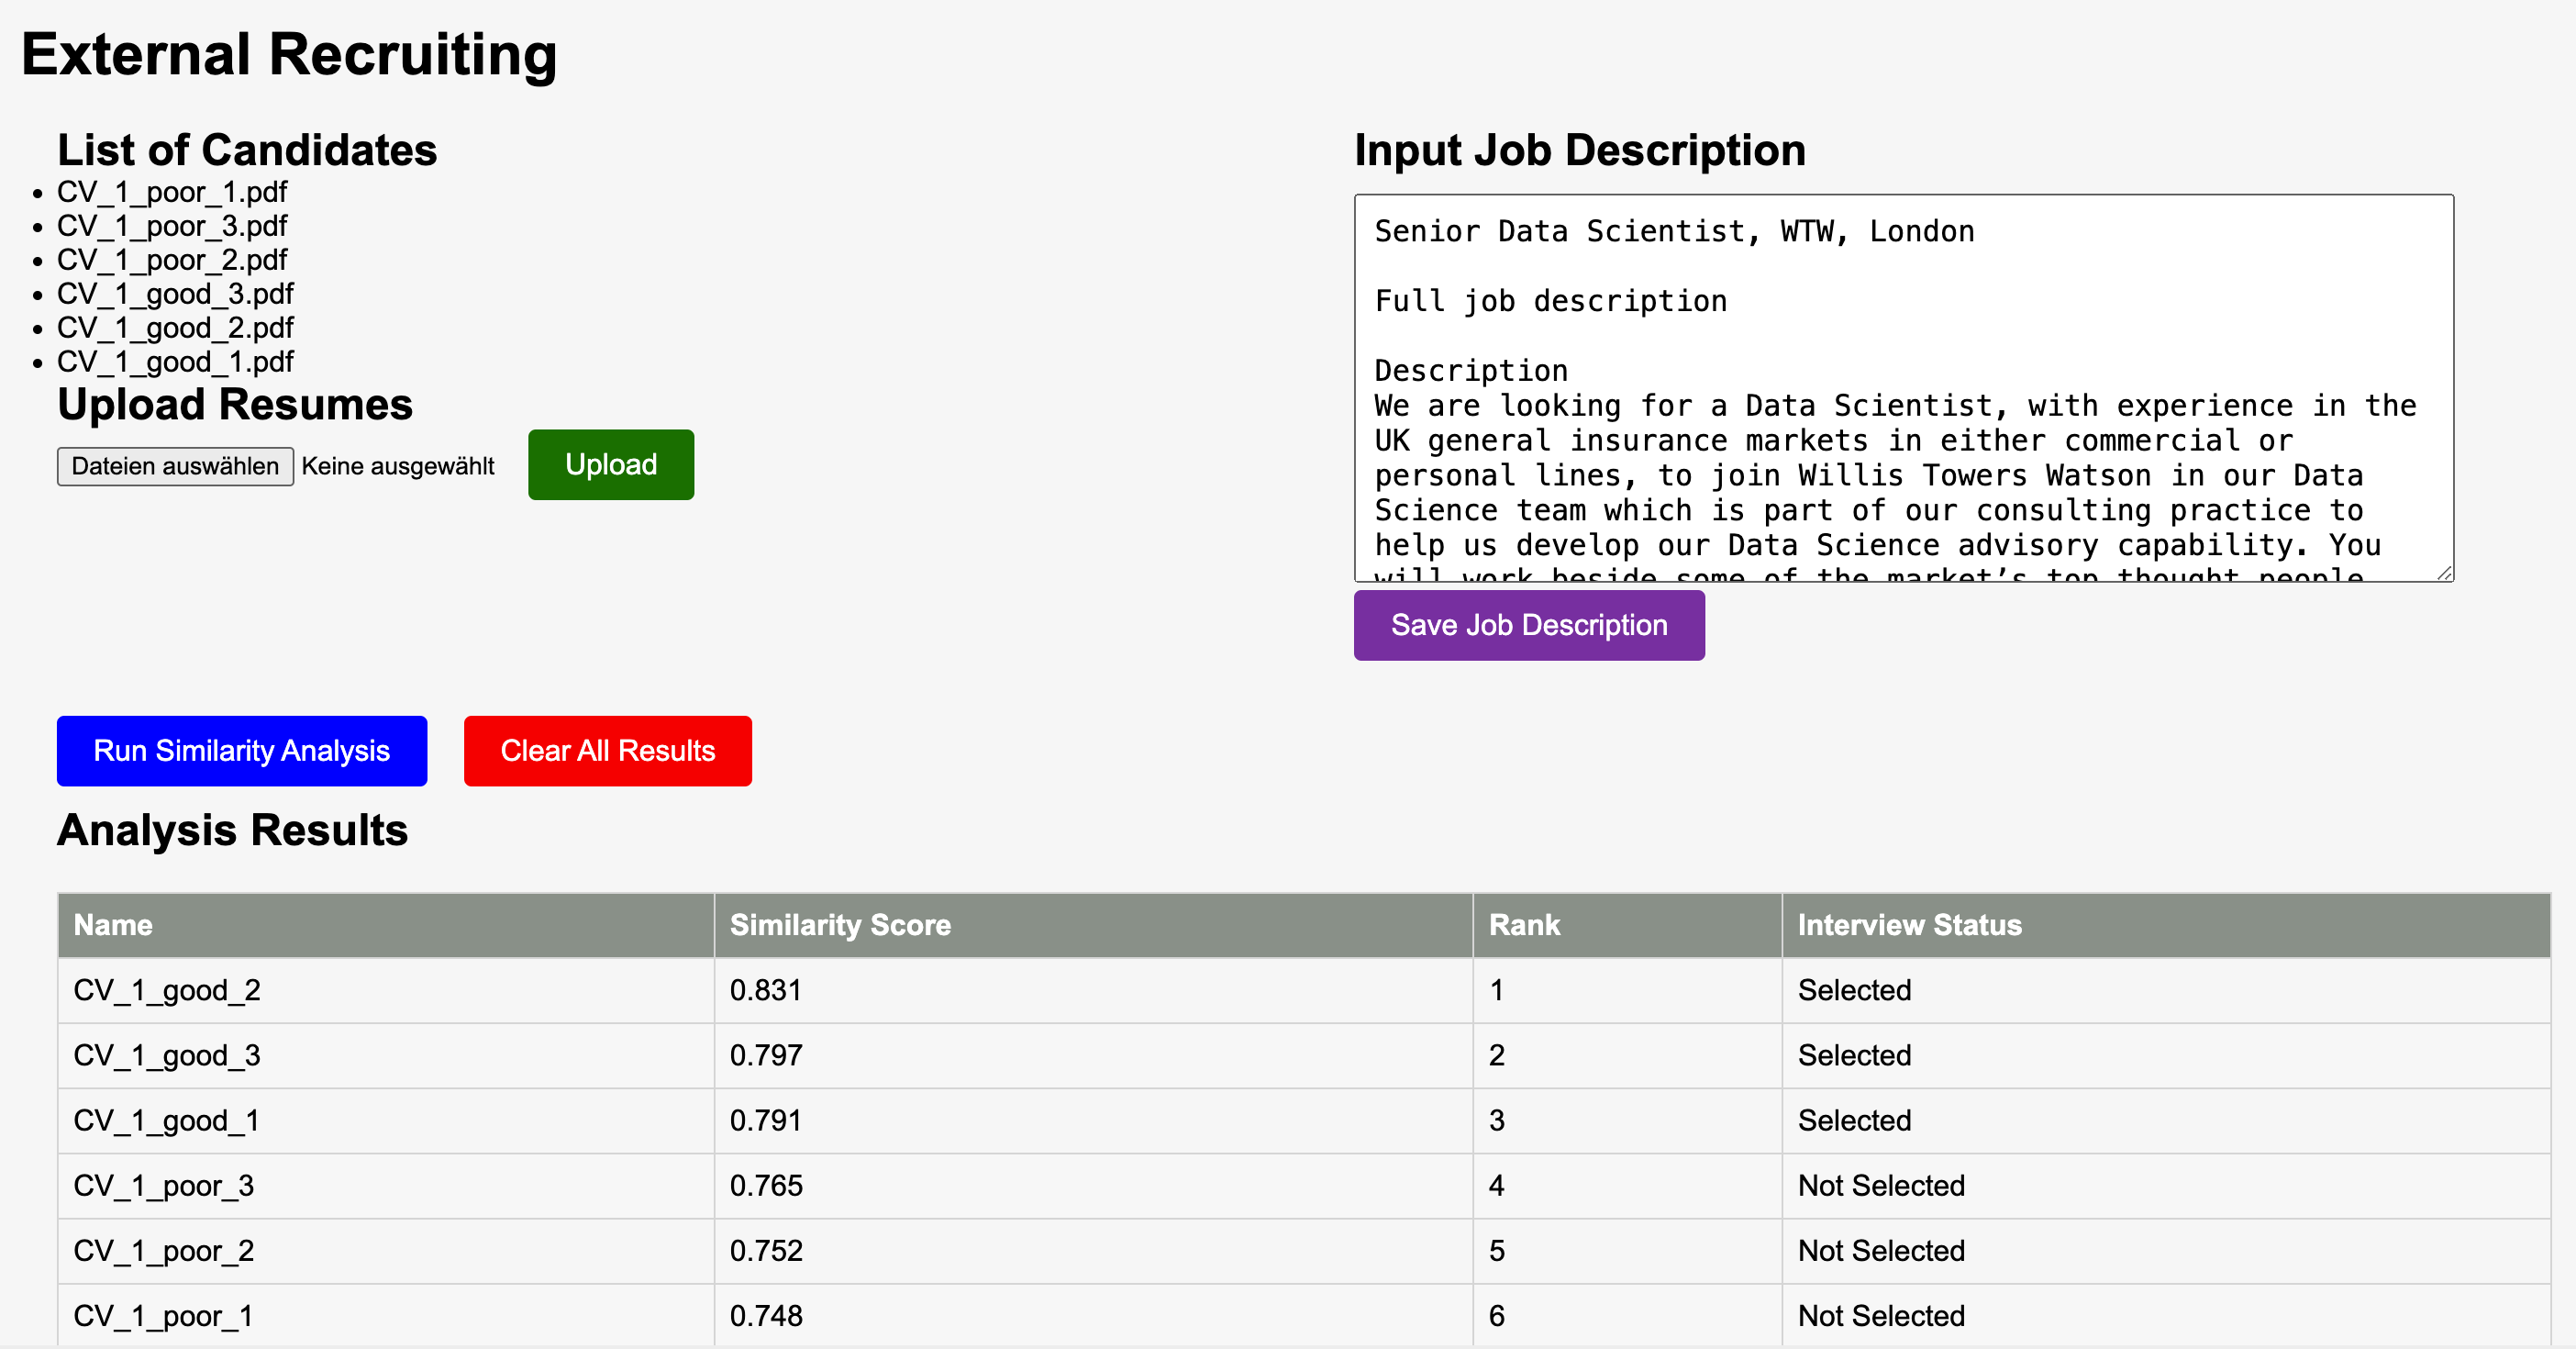